### Deep Learning Understanding
- Set of algorithms that were developed to train artificial neural networks with many layers most efficiently.
    - Can be used to create feature detectors** from unlabeled data to pre-train deep nueral networks.
    - Example use cases
        - Google's image search, Google Translate
        - Facebook's DeepFace for images, computer vision
        - Baidu's DeepSpeach, voice queries in Mandarin
        - Pharmaceutical indstury research


--- 

### Multi Layer Neural Network Architecture

- Special type of network is also called a **multi-layer perceptron (MLP)**
- One input layer, One hidden layer, One output layer
- We can think of the number of layers as additional **hyperparameters**
- Error gradients that we calculate via **backpropagation** would become increasingly small as more layers are added.  
- MLP is a **feedforward** approach, each layer serves as the input to the next, without loops. In contrast with **recurrent neural network**

--- 

### Activating a neural network via forward propagation


__Steps for the process of forward propagation to calculate the output of an MLP model.__

1) Starting at the input layer, we forward propagate the patterns of the training data through the network to generate an output.  
2) Based on the network's output, we calculate the error that we want to minimize using a cost function.  
3) We backpropagate the error, find it's derivative with respect to each weight in the network, and update the model

---

### Example MLP - Part 1 - Loading dataset
- Classify handwritten digits from the **MNIST** dataset (Mixed National Institute of Standards and Technology)
- Dataset is available at http://yann.lecun.com/exdb/mnist/

##### Unzipping files using gzip tool 

In [1]:
%%bash
gzip ../data/MNIST/*ubyte.gz -d

##### Function for loading the daasets

In [9]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    
    # Corresponding target variable, (integers 0-9 of handwritten digits)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
     
    # n x m dimensional array (28x28 pixels) 
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784) # 784 per row/image (28x28) 1D vector
        
    return images, labels

##### Load the 60k samples from training dataset

In [10]:
X_train, y_train = load_mnist('../data/MNIST/', kind='train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

Rows: 60000, columns: 784


##### Load the 10k samples from test dataset

In [12]:
X_test, y_test = load_mnist('../data/MNIST/', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 10000, columns: 784


##### Visualize examples of the 0-9 digits

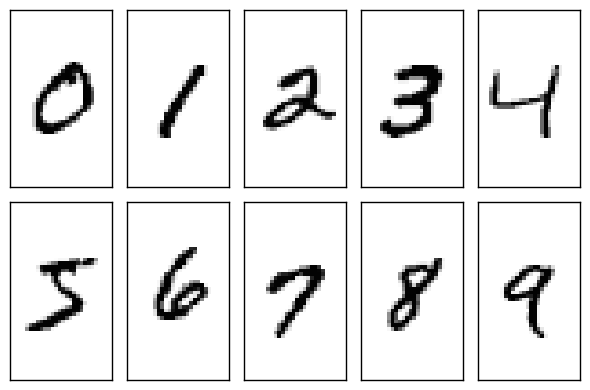

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True) # 2x5 subfigures
ax = ax.flatten()

for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28) # Reshape the 784-pixel vectors into original 28x28 image
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    
ax[0].set_xticks([]); ax[1].set_yticks([]);
plt.tight_layout(); 

##### Visualize examples of the same digit to see the differences between them

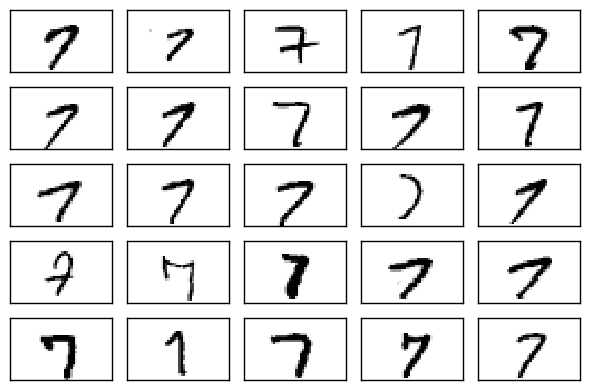

In [21]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    
ax[0].set_xticks([]); ax[1].set_yticks([]);
plt.tight_layout(); 

##### Optional - Save the datasets as CSV files for other programs/usage

In [ ]:
np.savetxt('train_img.csv', X_train, fmt='%i', delimiter=',')
np.savetxt('train_labels.csv', y_train, fmt='%i', delimiter=',')
np.savetxt('test_img.csv', X_test, fmt='%i', delimiter=',')
np.savetxt('test_labels.csv', y_test, fmt='%i', delimiter=',')

### Example MLP - Part 2 - Implementing a multi-layer perceptron (MLP)

In [27]:
import numpy as np
from scipy.special import expit
import sys

class NeuralNetMLP(object):
    def __init__(self, n_output, n_features, n_hidden=30, l1=0.0, l2=0.0, epochs=500, eta=0.001,
                alpha=0.0, decrease_const=0.0, shuffle=True, minibatches=1, random_state=None):
        
        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1, self.l2 = l1, l2
        self.epochs = epochs # Number of passes over the training set
        self.eta = eta       # The learning rate, n
        self.alpha = alpha   # Momentum learning to add a factor of prev gradient to weight update for faster learning
        self.decrease_const = decrease_const # decrease constant for an adaptive learning rate n that decreases ot
        self.shuffle = shuffle # Shuffle the training set prior to every epoch 
        self.minibatches = minibatches # Splitting training data into k mini-batches in each epoch. 
        
    def _encode_labels(self, y, k):
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot
    
    def _initialize_weights(self):
        w1 = np.random.uniform(-1.0, 1.0, size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0, size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2
    
    def _sigmoid(self, z):
        # Expit is equivalent to 1.0/(1.0 + np.exp(-z))
        return expit(z)
    
    def _sigmoid_gradient(self, z):
        sg = self._sigmoid(z)
        return sg * (1-sg)
    
    def _add_bias_unit(self, X, how='column'):
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1]+1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new
    
    def _feedforward(self, X, w1, w2):
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3
    
    def _L2_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))
    
    def _L1_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() + np.abs(w2[:, 1:]).sum())
    
    def _get_cost(self, y_enc, output, w1, w2):
        term1 = -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost
    
    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        # backpropagation
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)
        
        # regularize
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))
        
        return grad1, grad2
    
    def predict(self, X):
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred
    
    def fit(self, X, y, print_progress=False):
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)
        
        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        
        for i in range(self.epochs):
            
            # adaptive learning rate
            self.eta /= (1 + self.decrease_const*i)
            
            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
                
            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]
                
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            
            for idx in mini:
                # feedforward
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx], output=a3, w1=self.w1, w2=self.w2)
                self.cost_.append(cost)
                
                # compute gradient via backpropagation
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2, a3=a3, z2=z2, y_enc=y_enc[:, idx], w1=self.w1, w2=self.w2)
                
                # update weights
                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
                
        return self
                

#### Initialize a new 784-50-10 MLP ( 784 inputs , 50 hidden units, 10 ouput units )

In [28]:
nn = NeuralNetMLP(n_output=10, n_features=X_train.shape[1], n_hidden=50, l2=0.1, l1=0.0, epochs=1000, eta=0.001,
                  alpha=0.001, decrease_const=0.00001, shuffle=True, minibatches=50, random_state=1)

#### Train the MLP using 60k samples from the already shuffled training dataset (*note: this will take a while)

In [29]:
nn.fit(X_train, y_train, print_progress=True)

Epoch: 1000/1000

#### Visualize the cost_ list, verify convergence.

- Graph of cost function looks very noisy. This is due to training with mini-batch learning, a variant of stochastic gradient descent.
- Converged after approx. 800 epochs (40,000 / 50 = 800)

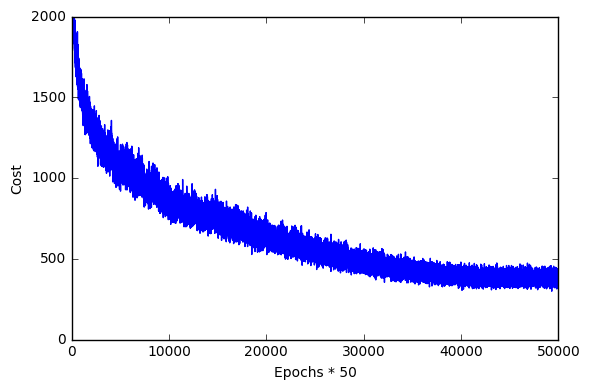

In [31]:
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs * 50') # Plot every 50th step to account for the 50 mini-batches
plt.tight_layout()
plt.show()

#### Smoother version of cost function by averaging over the mini-batch intervals

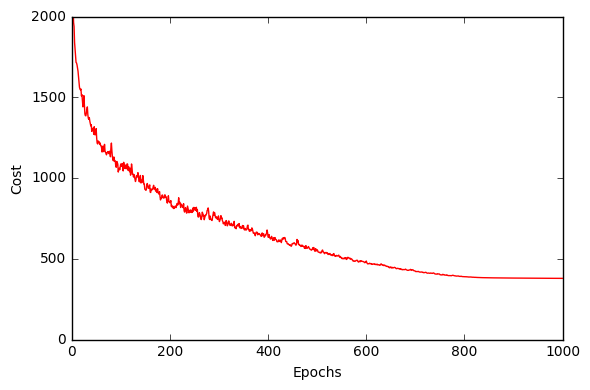

In [32]:
batches = np.array_split(range(len(nn.cost_)), 1000)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

#### Evaulate the performance of the model, prediction accuracy - Already seen data

In [34]:
y_train_pred = nn.predict(X_train)
acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]
print('Training accuracy: %.2f%%' % (acc * 100))

Training accuracy: 97.49%


#### Evaulate the performance of the model, prediction accuracy - Data that is not seen before

In [35]:
y_test_pred = nn.predict(X_test)
acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]
print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 95.90%


#### Evaulate images that our MLP model struggles with

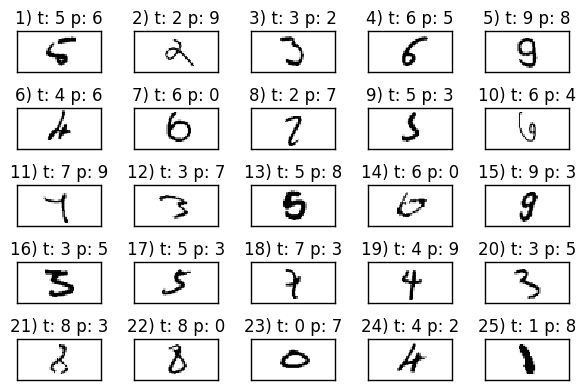

In [38]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()